# Shannon Entropy labelling learning

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR

import time

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
# entropy labelling
def ent_label(probas):
    info_con = (-1)*np.log2(probas)
    # entropy
    Hp = np.sum(np.multiply(probas, info_con))
    # クラス数変えると，probaでのindexがそのままlabelとして使えないのでs_cls内を参照させる
    labels = np.array([i for i, Ipk in enumerate(info_con) if Ipk <= Hp])
    if len(labels) == 0:
        print("no label")
    
    return labels

In [3]:
# duplicating images k-1 times, for k-labels
def dup_imgs(img, labels):
    k = len(labels)
    if k == 1:
        #print(img.shape)
        return np.array(img)
    else:
        tmp_dup = np.array([img for _ in range(k)])
        #print(tmp_dup.shape)
        return tmp_dup

In [4]:
def entropy_learning(orig_A, lim_A, dataset):
    
    model = LR().fit(train_imgs[orig_A:orig_A + lim_A], train_labels[orig_A:orig_A + lim_A])
    acc = accuracy_score(test_labels, model.predict(test_imgs))
    print(f"learnt with original labels: {acc*100}[%]")

    # generate an annotator
    a1_model = LR().fit(train_imgs[:orig_A], train_labels[:orig_A])
    a1_proba = a1_model.predict_proba(train_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [ent_label(probas) for probas in a1_proba]
    m_labels = []

    for labels in mul_labels:
         [m_labels.append(l) for l in labels]
    
    # images duplication
    dupld_imgs = np.array([dup_imgs(img, mul_labels[i]) for i, img in enumerate(train_imgs[orig_A:orig_A + lim_A])])

    d_imgs = []

    for img in dupld_imgs:
        a = img.shape
        n = a[0]
        if (n == img_SIZE):
            d_imgs.append(img)
        else:
            for _ in range(n):
                d_imgs.append(img[0])

    d_imgs = np.array(d_imgs)
    
    # 画像の複製確認 不要ならコメントアウト
    plt.figure(figsize = (15, 3))
    for i in range(len(d_imgs[:100])):
        plt.subplot(4, 25 , i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid('off')
        if (dataset == "mnist"):
            plt.imshow(d_imgs[i].reshape(28, 28), cmap = plt.cm.binary)
        elif (dataset == "cifar10" or dataset == "cifar100"):
            plt.imshow(d_imgs[i].reshape(32, 32, 3), cmap = plt.cm.binary)

    # final learning
    final_model = LR().fit(d_imgs, m_labels)
    acc = accuracy_score(test_labels, final_model.predict(test_imgs))
    return acc*100

#### ラベルづけからその正解率を評価まで行う関数

In [5]:
# labelling and evaluating them
def entropy_eval(orig_A, lim_A, dataset):

    # generate an annotator
    a1_model = LR().fit(train_imgs[:orig_A], train_labels[:orig_A])
    acc = accuracy_score(test_labels, a1_model.predict(test_imgs))
    print(f"annotator's ability: {acc*100}[%]")
    
    a1_proba = a1_model.predict_proba(train_imgs[orig_A:orig_A + lim_A])
    # entropy labelling
    mul_labels = [ent_label(probas) for probas in a1_proba]
    
    # labels score evaluation
    score = 0
    for labels, t_label in zip(mul_labels, train_labels[orig_A:orig_A + lim_A]):
        for l in labels:
            if (l == t_label):
                score += 1

    m_labels = []
    for labels in mul_labels:
         [m_labels.append(l) for l in labels]                
                    
    return (len(m_labels)/lim_A, score*100/len(m_labels)) 

## MNIST

In [6]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

img_SIZE = train_images.shape[1]*train_images.shape[2]

Using TensorFlow backend.


### learning

learnt with original labels: 84.48[%]
entropy labelled learning: 81.67999999999999[%]


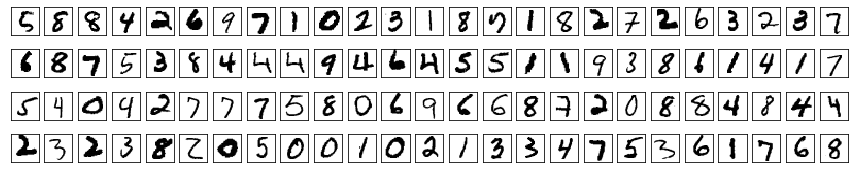

In [7]:
orig_A1, lim_A1 = 2000, 2000
dataset = "mnist"
mnist_result = entropy_learning(orig_A1, lim_A1, dataset)
print(f"entropy labelled learning: {mnist_result}[%]")

### labels evaluation

In [8]:
orig_A1, lim_A1 = 2000, 2000
dataset = "mnist"
(ave_l_num, labels_qual) = entropy_eval(orig_A1, lim_A1, dataset)
print(f"quality of labels generated: {labels_qual}[%]")
print(f"average number of labels per image: {ave_l_num}")

annotator's ability: 83.04[%]
quality of labels generated: 82.1207798383262[%]
average number of labels per image: 1.0515


## CIFAR 10

In [9]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# number of data samples
train_N, test_N = train_images.shape[0], test_images.shape[0]
# data normalisation and vecotrise
train_imgs, test_imgs = train_images.reshape(train_N, -1)/255, test_images.reshape(test_N, -1)/255
# labels ravel
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()

img_SIZE = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

# rgb画像なので，3つ組1つが各pixelの色(rgb値)を決める この3の一つ一つをチャンネルとよぶらしい
# データの一つ一つは32x32x3の画像 -> ravelすることで32*32*3がフラットに
# https://keras.io/datasets/
print(f"images shape transformation; {train_images.shape} -> {train_imgs.shape}\n")

images shape transformation; (50000, 32, 32, 3) -> (50000, 3072)



### learning

learnt with original labels: 28.96[%]
entropy labelled learning: 27.279999999999998[%]


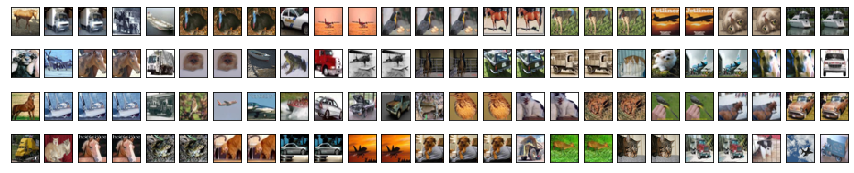

In [10]:
orig_A2, lim_A2 = 2000, 2000
dataset = "cifar10"
cifar10_result = entropy_learning(orig_A2, lim_A2, dataset)
print(f"entropy labelled learning: {cifar10_result}[%]")

### labels evaluation

In [11]:
orig_A2, lim_A2 = 2000, 2000
dataset = "cifar10"
(ave_l_num, labels_qual) = entropy_eval(orig_A2, lim_A2, dataset)
print(f"quality of labels generated: {labels_qual}[%]")
print(f"average number of labels per image: {ave_l_num}")

annotator's ability: 28.92[%]
quality of labels generated: 25.33375715193897[%]
average number of labels per image: 1.573


## CIFAR100

In [12]:
from keras.datasets import cifar100

(train_images, train_labels), (test_images, test_labels) = cifar100.load_data(label_mode = "fine")

# number of data samples
train_N, test_N = train_images.shape[0], test_images.shape[0]
# data normalisation and vecotrise
train_imgs, test_imgs = train_images.reshape(train_N, -1)/255, test_images.reshape(test_N, -1)/255
# labels ravel
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()

img_SIZE = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

### learning

learnt with original labels: 7.720000000000001[%]
entropy labelled learning: 4.93[%]


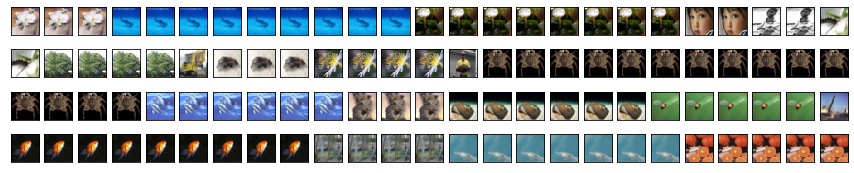

In [13]:
orig_A3, lim_A3 = 1000, 1000
dataset = "cifar100"
cifar100_result = entropy_learning(orig_A3, lim_A3, dataset)
print(f"entropy labelled learning: {cifar100_result}[%]")

### labels evaluation

In [14]:
orig_A3, lim_A3 = 1000, 1000
dataset = "cifar100"
(ave_l_num, labels_qual) = entropy_eval(orig_A3, lim_A3, dataset)
print(f"quality of labels generated: {labels_qual}[%]")
print(f"average number of labels per image: {ave_l_num}")

annotator's ability: 7.04[%]
quality of labels generated: 3.8848631239935587[%]
average number of labels per image: 4.968
